# Tutorial
---
Notebook contains explict constructions of circuits and functions for minimazation that are consider in article: *G. Czelusta, J. Mielczarek, **Quantum circuits for the Ising spin networks***

We use **Penny Lane** Python library.

All names used in this notebook are the same as in the  article and all references are refrences to the article.

In this tutorial simulators without statistical noise are used. Also used methods gradient computations are non compatible with real quantum hardware. Result with finite number of shots and real device compatible gradient computations are presented in notebook ```results.ipynb```.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

First we construct quantum circuit representing operator $W$:

In [2]:
def W(wires):
    qml.PauliX(wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.PauliX(wires=wires[1])
    qml.CRY(2*np.arccos(1/np.sqrt(3)), wires=[wires[1],wires[0]])
    qml.PauliX(wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.Hadamard(wires=wires[0])
    qml.T(wires=wires[0])
    qml.adjoint(qml.T)(wires=wires[1])
    qml.CNOT(wires=[wires[1],wires[0]])
    qml.adjoint(qml.T)(wires=wires[0])
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.T(wires=wires[0])
    qml.adjoint(qml.T)(wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[2]])
    qml.CNOT(wires=[wires[1],wires[3]])
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.Hadamard(wires=wires[2])
    qml.CNOT(wires=[wires[2],wires[3]])

then we construct quantum circuit wich construct state of single link, in the article we use singlet states, but you can choose arbitrary states
$$|\mathcal{B},\frac{1}{2}\rangle=\frac{1}{\sqrt{2}}\left(|01\rangle-|10\rangle\right)$$

In [3]:
def link(wires):
    qml.PauliX(wires=wires[0])
    qml.PauliX(wires=wires[1])
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])

## Dipole

Here we construct dipole state using four links:

$$|\Gamma_2,\mathcal{B},\frac{1}{2}\rangle=P_\Gamma\otimes_{l\in\Gamma_2}|\mathcal{B},\frac{1}{2}\rangle=\frac{1}{\sqrt{2}}\left(|\iota_0\iota_0\rangle+|\iota_1\iota_1\rangle\right)$$

we need 8 qubits

In [13]:
dev8 = qml.device('lightning.qubit', wires=8) # we use simulator 'lightning.qubit', you can choose for example 'default.qubit'
# dev8 = qml.device('lightning.qubit', wires=8, shots=20000) # you can also add 'shots=' and then obtain results with statistical noise simulated

then we construct circuit Fig.9

In [8]:
# @qml.qnode(dev8, diff_method="parameter-shift") # you can add 'diff_method=', or choose other, to use comaptible with real quantum devices methods
@qml.qnode(dev8)
def cost_circ(initial_layer_weights, weights):
    link([0,4])
    link([1,5])
    link([2,6])
    link([3,7])

    qml.adjoint(W)([0,1,2,3])
    qml.adjoint(W)([4,5,6,7])

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,4])
        
    return qml.probs(wires=range(8))

Here we define function which post-selects measurements to obtain projected state

In [9]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'08b')
        if k[1:4]=='000' and k[5:8]=='000':
            c[k[0]+k[4]] = probs[i]
    return c['00']/np.sum(list(c.values()))

We define cost function, Eq. 21

In [10]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

We can check cost function on some random parameters.

Variable ```initial_layer_weights``` needs to have shape $(N)$, where $N$ is number of qubits in anstaz, in this case $N=2$.

Variable ```weights``` needs to have shape $(L,N-1,2)$, where $L$ is number of layers in ansatz, $N$ is number of qubits in anstaz, in this case $L=1$, $N=2$.

For more details, see Fig. 8 and documentation of ```SimplifiedTwoDesign```.

In [11]:
initial_layer_weights=np.random.rand(2)*2*np.pi
weights=np.random.rand(1,1,2)*2*np.pi
cost_fn(initial_layer_weights, weights)

tensor(0.34607583, requires_grad=True)

Then we can optimize our ansatz. We choose classical optimizer, here ```AdamOptimizer```, maximal number of iteration in optimization loop, here $100$ and converge tolerance, here $10^{-6}$. We initialize parameters randomly. At the end we plot history of cost function during minimalization.

Iteration = 0,  Cost = 0.56165631
Iteration = 20,  Cost = 0.05143240
Iteration = 40,  Cost = 0.00686990
Iteration = 60,  Cost = 0.00050189
Iteration = 80,  Cost = 0.00010077


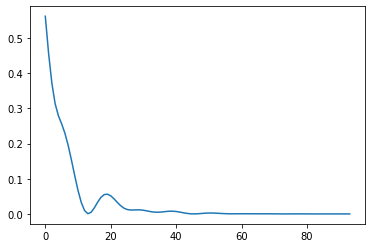

In [12]:
opt = qml.AdamOptimizer(stepsize=0.1)

max_iterations = 100
conv_tol = 1e-06

init_params = [np.random.rand(2)*2*np.pi, np.random.rand(1,1,2)*2*np.pi]

params = init_params

cost = 0

costs=[]
paramses = []
paramses.append(params)


for n in range(max_iterations):
    params, prev_cost = opt.step_and_cost(cost_fn, *params)
    conv = np.abs(cost - prev_cost)
    cost=prev_cost
    costs.append(cost)
    paramses.append(params)
    
    if n % 20 == 0:
        print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

    if conv <= conv_tol:
        break
    
plt.rcParams['figure.figsize'] = [10,5]

plt.plot(costs)

We can now compute fidelity of obtained state. We execute ansatz with optimized parameters and check if it reproduces dipole state:

In [13]:
def fidelity_dipole(params):
    @qml.qnode(qml.device('lightning.qubit', wires=2))
    def dipole(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=[0,1])
        return qml.state()

    dipole_exact = [1/np.sqrt(2),0,0,1/np.sqrt(2)]

    return np.abs(np.dot(dipole(params), dipole_exact))

In [14]:
dipole_params = params

In [15]:
fidelity_dipole(dipole_params)

0.999989682777915

In similar way we can construct states for larger spin netorks. But construction starting from single links is not the most optimal one. Therefore, we show construction by gluing spin networks.

## Single node with free links

First, we need to prepare state of sningle node with four free links. We construct circuit, Fig. 19. It can be also seen as open dipole.

In [14]:
@qml.qnode(dev8)
def cost_circ(initial_layer_weights, weights):
    link([0,4])
    link([1,5])
    link([2,6])
    link([3,7])

    qml.adjoint(W)([0,1,2,3])

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,4,5,6,7])
        
    return qml.probs(wires=range(8))

In [15]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'08b')
        if k[1:4]=='000':
            c[k[0]+k[4:]] = probs[i]
    return c['00000']/np.sum(list(c.values()))

In [16]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

Iteration = 0,  Cost = 0.96597145
Iteration = 20,  Cost = 0.14820930
Iteration = 40,  Cost = 0.02151843
Iteration = 60,  Cost = 0.00286865
Iteration = 80,  Cost = 0.00021646


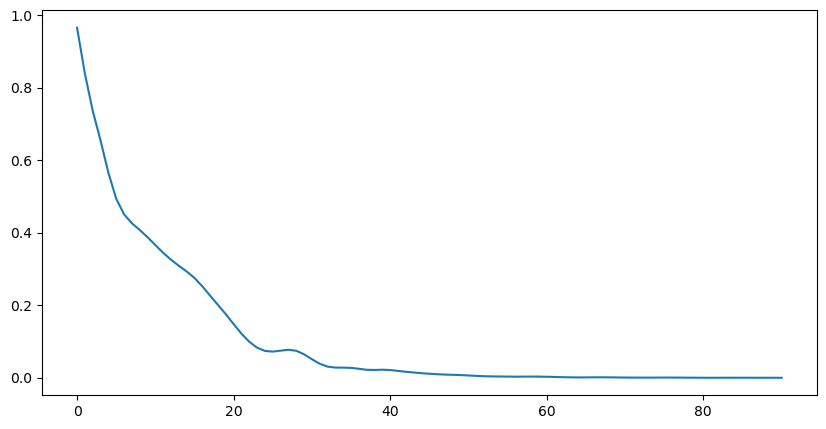

In [17]:
opt = qml.AdamOptimizer(stepsize=0.1)

max_iterations = 100
conv_tol = 1e-06

init_params = [np.random.rand(5)*2*np.pi, np.random.rand(4,4,2)*2*np.pi]

params = init_params

cost = 0

costs=[]
paramses = []
paramses.append(params)


for n in range(max_iterations):
    params, prev_cost = opt.step_and_cost(cost_fn, *params)
    conv = np.abs(cost - prev_cost)
    cost=prev_cost
    costs.append(cost)
    paramses.append(params)
    
    if n % 20 == 0:
        print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

    if conv <= conv_tol:
        break
    
plt.rcParams['figure.figsize'] = [10,5]

plt.plot(costs)

In [18]:
def fidelity_node(params):
    @qml.qnode(qml.device('default.qubit', wires=5))
    def node(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=range(5))
        return qml.state()

    node_exact = [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.35355339, -0.35355339,  0.        ,  0.        , -0.35355339,
        0.35355339,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.40824829,
        0.        , -0.20412414, -0.20412414,  0.        ,  0.        ,
       -0.20412414, -0.20412414,  0.        ,  0.40824829,  0.        ,
        0.        ,  0.        ]

    return np.abs(np.dot(node(params), node_exact))

In [19]:
node_params = params

In [20]:
fidelity_node(node_params)

0.9999338690049115

## Pentagram

In [21]:
dev17 = qml.device('lightning.qubit', wires=17)

In [22]:
pentagram_links = [[2,6],[3,10],[4,14],[7,11],[8,15],[12,16]]

In [23]:
@qml.qnode(dev17)
def cost_circ(initial_layer_weights, weights):
        
    qml.adjoint(qml.SimplifiedTwoDesign)(node_params[0],node_params[1],wires=[0,1,5,9,13])

    for l in pentagram_links:
        link(l)

    qml.adjoint(W)([1,2,3,4])
    qml.adjoint(W)([5,6,7,8])
    qml.adjoint(W)([9,10,11,12])
    qml.adjoint(W)([13,14,15,16])

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,1,5,9,13])
        
    return qml.probs(wires=range(17))

In [24]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'017b')
        if k[2:5]=='000' and k[6:9]=='000' and k[10:13]=='000' and k[14:17]=='000':
            c[k[0]+k[1]+k[5]+k[9]+k[13]] = probs[i]
    if np.sum(list(c.values()))==0:
        return 0
    else:
        return c['00000']/np.sum(list(c.values()))

In [25]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

Iteration = 0,  Cost = 0.98942392
Iteration = 20,  Cost = 0.11311338
Iteration = 40,  Cost = 0.01603401


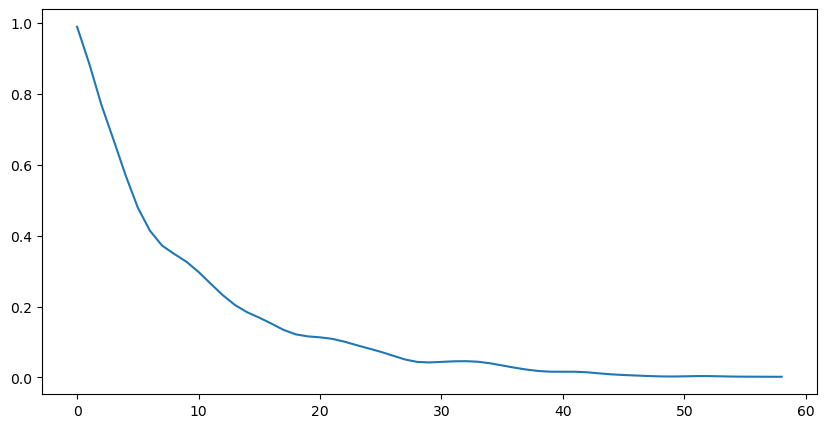

In [26]:
opt = qml.AdamOptimizer(stepsize=0.1)

max_iterations = 100
conv_tol = 1e-06

init_params = [np.random.rand(5)*2*np.pi, np.random.rand(4,4,2)*2*np.pi]
params = init_params


cost = 0

costs=[]
paramses = []
paramses.append(params)

for n in range(max_iterations):
    params, prev_cost = opt.step_and_cost(cost_fn, *params)
    conv = np.abs(cost - prev_cost)
    cost=prev_cost
    costs.append(cost)
    paramses.append(params)
    
    if conv <= conv_tol:
        break

    if n % 20 == 0:
        print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

plt.rcParams['figure.figsize'] = [10,5]

plt.plot(costs)

In [27]:
def fidelity_pentagram(params):
    @qml.qnode(qml.device('default.qubit', wires=5))
    def pentagram(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=[0,1,2,3,4])
        return qml.state()

    pentagram_exact = 1/np.sqrt(14)*np.array([3/2,0,0,3/2,0,0,0,0,0,0,0,0,0,-np.sqrt(3)/2,-np.sqrt(3)/2,1,0,0,0,0,0,-np.sqrt(3)/2,-np.sqrt(3)/2,-1,3/2,0,0,-1/2,0,-1,1,0])

    return np.abs(np.dot(pentagram(params), pentagram_exact))

In [28]:
pentagram_params = params

In [29]:
fidelity_pentagram(pentagram_params)

0.9989885149164583

## Open pentagram, i.e. 4-node network with four open links

Similarly we prepare open pentagram by ommiting one of $W^\dagger$.

In [40]:
dev20 = qml.device('default.qubit', wires=20)

In [41]:
pentagram_links = [[0,4],[1,8],[2,12],[3,16],[5,9],[6,13],[7,17],[10,14],[11,18],[15,19]]

In [42]:
@qml.qnode(dev20)
def cost_circ(initial_layer_weights, weights):
    for l in pentagram_links:
        link(l)

    qml.adjoint(W)([0,1,2,3])
    qml.adjoint(W)([4,5,6,7])
    qml.adjoint(W)([8,9,10,11])
    qml.adjoint(W)([12,13,14,15])

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,4,8,12,16,17,18,19])
        
    return qml.probs(wires=range(20))

In [43]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'020b')
        if k[1:4]=='000' and k[5:8]=='000' and k[9:12]=='000' and k[13:16]=='000':
            c[k[0]+k[4]+k[8]+k[12]+k[16:]] = probs[i]
    if np.sum(list(c.values()))==0:
        return 0
    else:
        return c['00000000']/np.sum(list(c.values()))

In [44]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

Iteration = 0,  Cost = 0.99340092
Iteration = 20,  Cost = 0.33364838
Iteration = 40,  Cost = 0.17403134
Iteration = 60,  Cost = 0.08272770
Iteration = 80,  Cost = 0.07204587


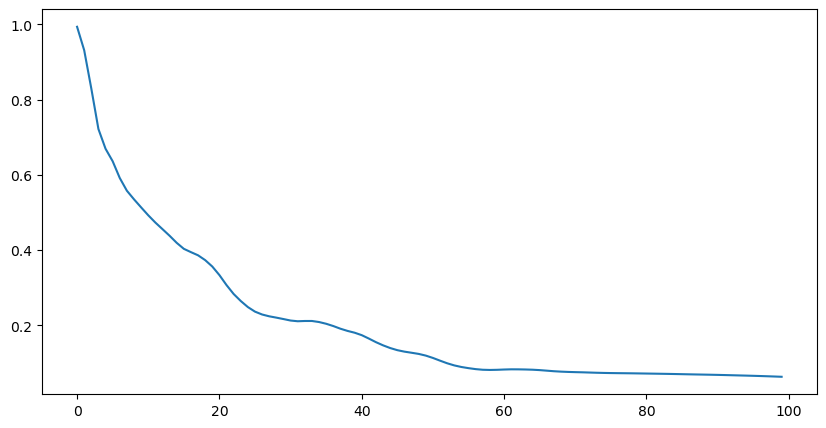

In [45]:
opt = qml.AdamOptimizer(stepsize=0.1)

max_iterations = 100
conv_tol = 1e-06

init_params = [np.random.rand(8)*2*np.pi, np.random.rand(5,7,2)*2*np.pi]

params = init_params

cost = 0

costs=[]
paramses = []
paramses.append(params)


for n in range(max_iterations):
    params, prev_cost = opt.step_and_cost(cost_fn, *params)
    conv = np.abs(cost - prev_cost)
    cost=prev_cost
    costs.append(cost)
    paramses.append(params)
    
    if n % 20 == 0:
        print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

    if conv <= conv_tol:
        break
    
plt.rcParams['figure.figsize'] = [10,5]

plt.plot(costs)

In [46]:
open_pentagram_params = params

In [47]:
def fidelity_open_pentagram(params):
    @qml.qnode(qml.device('default.qubit', wires=8))
    def open_pentagram(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=range(8))
        return qml.state()

    open_pentagram_exact = np.array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.00445933e-01, -2.00445933e-01,  0.00000000e+00,
        0.00000000e+00, -2.00445933e-01,  2.00445933e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.31455027e-01,
        0.00000000e+00, -1.15727512e-01, -1.15727512e-01,  0.00000000e+00,
        0.00000000e+00, -1.15727512e-01, -1.15727512e-01,  0.00000000e+00,
        2.31455027e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.44270058e-18,  3.44270058e-18,  0.00000000e+00,
        0.00000000e+00, -3.44270058e-18, -3.44270058e-18,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.08693648e-18,
        0.00000000e+00,  1.83706729e-19, -1.83706729e-19,  0.00000000e+00,
        0.00000000e+00,  1.83706729e-19, -1.83706729e-19,  0.00000000e+00,
       -2.08693648e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.44270058e-18, -3.44270058e-18,  0.00000000e+00,
        0.00000000e+00,  3.44270058e-18, -3.44270058e-18,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.70899527e-18,
        0.00000000e+00,  1.85449789e-18,  1.85449789e-18,  0.00000000e+00,
        0.00000000e+00, -1.85449789e-18, -1.85449789e-18,  0.00000000e+00,
       -3.70899527e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.33630622e-01,
        0.00000000e+00,  6.68153089e-02,  6.68153089e-02,  0.00000000e+00,
        0.00000000e+00,  6.68153089e-02,  6.68153089e-02,  0.00000000e+00,
       -1.33630622e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.54303348e-01,
        0.00000000e+00, -1.92879188e-01,  3.85758360e-02,  0.00000000e+00,
        0.00000000e+00,  3.85758360e-02, -1.92879188e-01,  0.00000000e+00,
        1.54303348e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.44270058e-18, -3.44270058e-18,  0.00000000e+00,
        0.00000000e+00,  3.44270058e-18, -3.44270058e-18,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.08693648e-18,
        0.00000000e+00,  1.83706729e-19,  1.83706729e-19,  0.00000000e+00,
        0.00000000e+00, -1.83706729e-19, -1.83706729e-19,  0.00000000e+00,
        2.08693648e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.33630622e-01,
        0.00000000e+00,  6.68153089e-02,  6.68153089e-02,  0.00000000e+00,
        0.00000000e+00,  6.68153089e-02,  6.68153089e-02,  0.00000000e+00,
       -1.33630622e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.54303348e-01,
        0.00000000e+00, -3.85758360e-02,  1.92879188e-01,  0.00000000e+00,
        0.00000000e+00,  1.92879188e-01, -3.85758360e-02,  0.00000000e+00,
       -1.54303348e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.00445931e-01, -2.00445931e-01,  0.00000000e+00,
        0.00000000e+00, -2.00445931e-01,  2.00445931e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.71516733e-02,
        0.00000000e+00,  3.85758387e-02,  3.85758387e-02,  0.00000000e+00,
        0.00000000e+00,  3.85758387e-02,  3.85758387e-02,  0.00000000e+00,
       -7.71516733e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.54303349e-01,
        0.00000000e+00,  7.71516746e-02,  7.71516746e-02,  0.00000000e+00,
        0.00000000e+00,  7.71516746e-02,  7.71516746e-02,  0.00000000e+00,
       -1.54303349e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.56420681e-18,
        0.00000000e+00,  1.33630620e-01, -1.33630620e-01,  0.00000000e+00,
        0.00000000e+00, -1.33630620e-01,  1.33630620e-01,  0.00000000e+00,
        8.76428875e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
    
    return np.abs(np.dot(open_pentagram(params), open_pentagram_exact))

In [48]:
fidelity_open_pentagram(open_pentagram_params)

0.9681320441392288

## Gluing two open pentagrams into decagram network

To glue two open pentagrams we need to use ansatz for open pentagram with optimized parameters.

We construct circuit, Fig. 17

In [52]:
dev16 = qml.device('lightning.qubit', wires=16)

In [53]:
@qml.qnode(dev16)
def cost_circ(initial_layer_weights, weights):
    qml.adjoint(qml.SimplifiedTwoDesign)(open_pentagram_params[0], open_pentagram_params[1], wires=range(8))
    qml.adjoint(qml.SimplifiedTwoDesign)(open_pentagram_params[0], open_pentagram_params[1],wires=range(8,16))

    qml.adjoint(W)([4,5,12,13])
    qml.adjoint(W)([6,7,14,15])

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,1,2,3,4,6,8,9,10,11])
        
    return qml.probs(wires=range(16))

In [54]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'016b')
        if (k[5]+k[12]+k[13])=='000' and (k[7]+k[14]+k[15])=='000':
            c[k[0:5]+k[6]+k[8]+k[9:12]] = probs[i]
    if np.sum(list(c.values()))==0:
        return 0
    else:
        return c[10*'0']/np.sum(list(c.values()))

In [55]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'016b')
        if (k[5]+k[12]+k[13])=='000' and (k[7]+k[14]+k[15])=='000':
            c[k[0:5]+k[6]+k[8]+k[9:12]] = probs[i]
    return c[10*'0']/np.sum(list(c.values()))

In [56]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

In [57]:
initial_layer_weights=np.random.rand(10)*2*np.pi
weights=np.random.rand(1,9,2)*2*np.pi
cost_fn(initial_layer_weights, weights)

tensor(0.99978935, requires_grad=True)

Iteration = 0,  Cost = 0.99986771
Iteration = 20,  Cost = 0.09786560
Iteration = 40,  Cost = 0.07411106
Iteration = 60,  Cost = 0.06584264
Iteration = 80,  Cost = 0.04476735


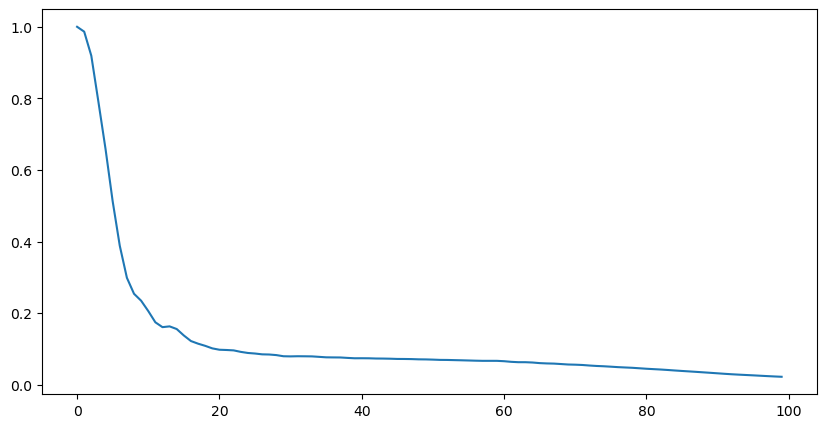

In [58]:
opt = qml.AdamOptimizer(stepsize=0.1)

max_iterations = 100
conv_tol = 1e-06

init_params = [np.random.rand(10)*2*np.pi, np.random.rand(6,9,2)*2*np.pi]

params = init_params

cost = 0

costs=[]
paramses = []
paramses.append(params)


for n in range(max_iterations):
    params, prev_cost = opt.step_and_cost(cost_fn, *params)
    conv = np.abs(cost - prev_cost)
    cost=prev_cost
    costs.append(cost)
    paramses.append(params)
    
    if n % 20 == 0:
        print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

    if conv <= conv_tol:
        break
    
plt.rcParams['figure.figsize'] = [10,5]

plt.plot(costs)

In [61]:
dekagram_params = params

In [64]:
import pandas as pd # we use pandas to read csv file that contains exact dekagram state

def fidelity_dekagram(params):
    @qml.qnode(qml.device('default.qubit', wires=10))
    def dekagram(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=range(10))
        return qml.state()
    
    dekagram_exact = np.zeros(2**10)
    for row in pd.read_csv('deka.csv').to_numpy():
        dekagram_exact[int(''.join(row[0].split(' ')),2)]=row[1]
    dekagram_exact = dekagram_exact/np.sqrt(np.dot(dekagram_exact, dekagram_exact))
    
    return np.abs(np.dot(dekagram(params), dekagram_exact))

In [65]:
fidelity_dekagram(dekagram_params)

0.9693205865460751

## Gluing two open nodes and four links into hexagram network

In [73]:
dev18 = qml.device('lightning.qubit', wires=18)

In [74]:
hexagram_links = [[10,14],[11,15],[12,16],[13,17]]

In [75]:
@qml.qnode(dev18)
def cost_circ(initial_layer_weights, weights):
        
    qml.adjoint(qml.SimplifiedTwoDesign)(node_params[0],node_params[1],wires=[0,1,2,3,4])
    qml.adjoint(qml.SimplifiedTwoDesign)(node_params[0],node_params[1],wires=[5,6,7,8,9])

    for l in hexagram_links:
        link(l)

    qml.adjoint(W)([1,7,10,12])
    qml.adjoint(W)([2,6,14,13])
    qml.adjoint(W)([3,9,11,17])
    qml.adjoint(W)([4,8,15,16])


    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,1,2,5,3,4])
        
    return qml.probs(wires=range(18))

In [76]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'018b')
        if (k[7]+k[10]+k[12])=='000' and (k[6]+k[14]+k[13])=='000' and (k[9]+k[11]+k[17])=='000' and (k[8]+k[15]+k[16])=='000':
            c[k[0]+k[1]+k[2]+k[5]+k[3]+k[4]] = probs[i]
    if np.sum(list(c.values()))==0:
        return 0
    else:
        return c['000000']/np.sum(list(c.values()))

In [77]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

Iteration = 0,  Cost = 0.99999684
Iteration = 20,  Cost = 0.30719299
Iteration = 40,  Cost = 0.11947789
Iteration = 60,  Cost = 0.06106249
Iteration = 80,  Cost = 0.05202596


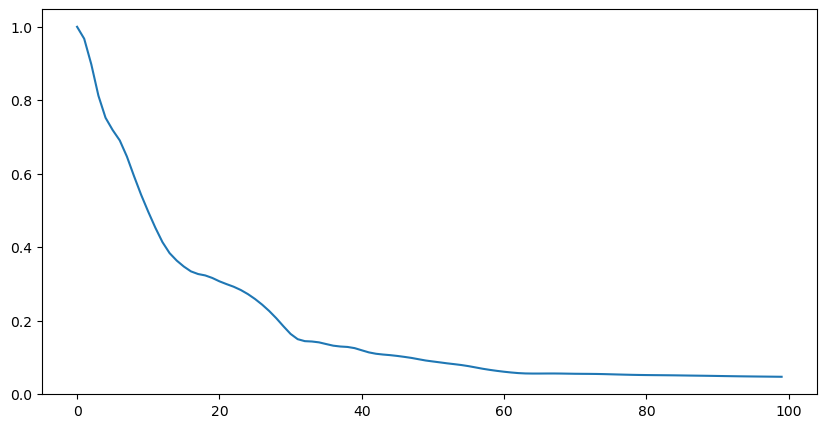

In [78]:
opt = qml.AdamOptimizer(stepsize=0.1)

max_iterations = 100
conv_tol = 1e-06

init_params = [np.random.rand(6)*2*np.pi, np.random.rand(4,5,2)*2*np.pi]

params = init_params

cost = 0

costs=[]
paramses = []
paramses.append(params)


for n in range(max_iterations):
    params, prev_cost = opt.step_and_cost(cost_fn, *params)
    conv = np.abs(cost - prev_cost)
    cost=prev_cost
    costs.append(cost)
    paramses.append(params)
    
    if n % 20 == 0:
        print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

    if conv <= conv_tol:
        break
    
plt.rcParams['figure.figsize'] = [10,5]

plt.plot(costs)

In [79]:
hexagram_params = params

In [80]:
def fidelity_hexagram(params):
    @qml.qnode(qml.device('default.qubit', wires=6))
    def hexagram(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=[0,1,2,3,4,5])
        return qml.state()

    hexagram_exact = np.array([-2.63342585e-01,  5.65370456e-19,  1.51490340e-19, -2.63342583e-01,
        5.65370456e-19, -3.04551051e-18, -6.03377231e-20, -1.75092612e-18,
       -1.51490340e-19,  6.03377231e-20, -1.21820390e-18,  3.22994982e-18,
        6.03377231e-20,  1.52040910e-01,  1.52040910e-01,  1.75561720e-01,
       -5.65370456e-19,  1.21820425e-18,  6.03377231e-20, -1.76234378e-18,
        1.21820425e-18,  1.52040910e-01,  1.52040910e-01,  1.75561720e-01,
       -2.63342583e-01, -2.41165196e-18, -4.53151247e-19, -2.63342580e-01,
        1.84628143e-18,  1.75561720e-01,  1.75561720e-01,  2.02721212e-01,
        5.65370456e-19, -3.04551051e-18, -6.03377231e-20, -1.60958351e-18,
       -2.63342583e-01, -4.20645312e-19, -3.43688977e-18,  8.77808601e-02,
        6.03377231e-20,  1.52040910e-01,  1.52040910e-01, -1.75561720e-01,
       -3.87233526e-18,  1.75561720e-01, -1.75561720e-01,  3.45439101e-18,
        1.21820425e-18,  1.52040910e-01,  1.52040910e-01, -1.75561720e-01,
        4.20645312e-19, -1.75561720e-01,  1.75561720e-01, -2.46726461e-18,
       -1.84628143e-18, -1.75561720e-01, -1.75561720e-01,  2.02721212e-01,
        8.77808601e-02,  4.30589915e-18, -6.50422488e-18, -2.92602864e-02])
    
    return np.abs(np.dot(hexagram(params), hexagram_exact))

In [81]:
fidelity_hexagram(hexagram_params)

0.9761047921000883